# Import

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from torch.optim import Adam
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sn
from tqdm import tqdm

In [ ]:
np.set_printoptions(precision=4)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Read Data

In [ ]:
# Constants
IMAGE_SIZE = (32, 32)
NUM_LETTERS = 28

In [2]:
!unzip "data.zip"

Archive:  data.zip
  inflating: TrainImgs.csv           
  inflating: TestImgs.csv            
  inflating: TestLabels.csv          
  inflating: TrainLabels.csv         


In [ ]:
train_images = pd.read_csv("TrainImgs.csv", header=None)
train_labels = pd.read_csv("TrainLabels.csv", header=None)

test_images = pd.read_csv("TestImgs.csv", header=None)
test_labels = pd.read_csv("TestLabels.csv", header=None)

print(f'Shape of test images: {test_images.shape}')
print(f'Shape of test labels: {test_labels.shape}')
print(f'Shape of train images: {train_images.shape}')
print(f'Shape of train labels: {train_labels.shape}')

Shape of test images: (3360, 1024)
Shape of test labels: (3360, 1)
Shape of train images: (13440, 1024)
Shape of train labels: (13440, 1)


In [ ]:
X_train = train_images.to_numpy().reshape((-1,1, *IMAGE_SIZE))
X_test = test_images.to_numpy().reshape((-1,1, *IMAGE_SIZE))
y_train = train_labels.to_numpy().squeeze() - 1 # Original labels are from 1 to 28
y_test = test_labels.to_numpy().squeeze() - 1

# EDA

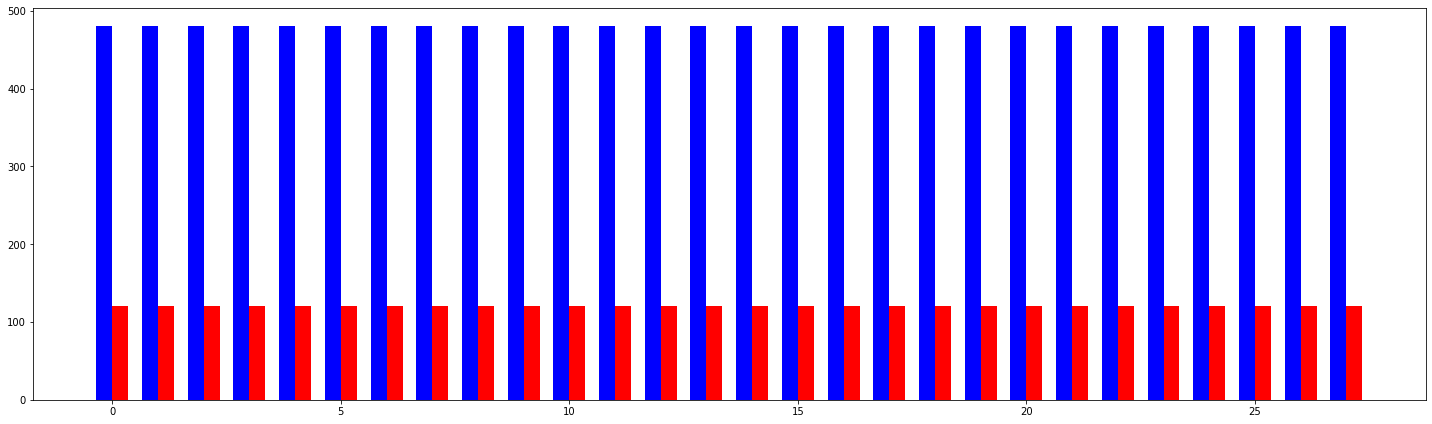

In [ ]:
plt.figure(figsize=(20, 6))
train_counts = [(y_train == i).sum() for i in range(NUM_LETTERS)]
test_counts = [(y_test == i).sum() for i in range(NUM_LETTERS)]
index = np.arange(NUM_LETTERS)

bar_width = 0.35
plt.bar(index - bar_width/2, train_counts, color='b', label='train', width=bar_width)
plt.bar(index + bar_width/2, test_counts, color='r', label='test', width=bar_width)

plt.tight_layout()
plt.show()

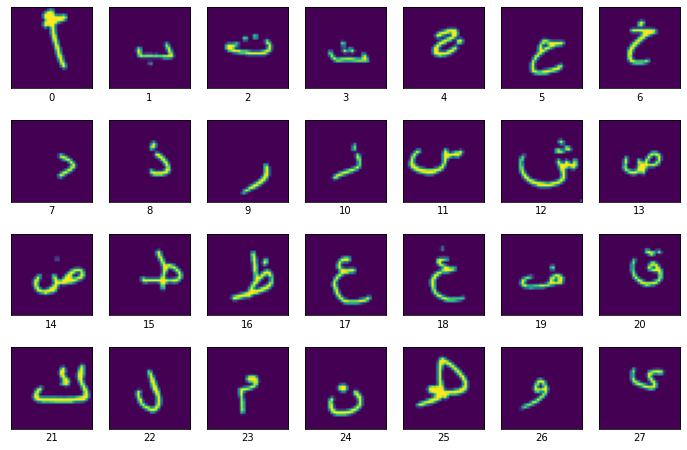

In [ ]:
plt.figure(figsize=(12, 8))
class_indices = [np for i in range(NUM_LETTERS)]
for i in range(NUM_LETTERS):
    index = np.random.choice(np.where(y_train == i)[0])
    plt.subplot(4, 7, i + 1)
    plt.imshow(X_train[index][0].T)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(i)

# Datasets and DataLoaders

In [ ]:
# Normalization
X_train = (X_train / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

In [ ]:
train_set = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_set = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=True)

# Model
For the model, I used [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network). It's a powerful convolutional model which takes advantage of skip connections in order to get rid of the vanishing gradient problem in deep networks.

In [ ]:
class ResidualClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.res1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.seq2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.res2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.seq3 = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=64, out_features=NUM_LETTERS)
        )


    def forward(self, x):
        y1 = self.seq1(x)
        y2 = self.res1(y1) + y1
        y3 = self.seq2(y2)
        y4 = self.res2(y3) + y3
        y5 = self.seq3(y4)
        return y5

# Defining the model and other parameters

In [ ]:
"torch.manual_seed(0)
model = ResidualClassifier()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]           2,320
              ReLU-5           [-1, 16, 16, 16]               0
            Conv2d-6           [-1, 16, 16, 16]           2,320
              ReLU-7           [-1, 16, 16, 16]               0
         MaxPool2d-8             [-1, 16, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]           9,280
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
             ReLU-12             [-1, 64, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          36,928
             ReLU-14             [-1, 6

# Training

In [ ]:
EPOCHS = 30

metrics = {
        'train loss': [], 'test loss': [],
        'train acc': [], 'test acc': [],
        'train f1': [], 'test f1': []
    }
for epoch in range(EPOCHS):
    train_loss, test_loss = 0, 0
    train_acc, test_acc = 0, 0
    model.train(True)
    all_preds = []
    all_labels = []
    for images, labels in train_loader:
        all_labels += labels
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs , labels)
        loss.backward()
        optimizer.step()

        all_preds += torch.argmax(outputs, 1).to('cpu')
        train_loss += loss
    scheduler.step()
    train_acc = sum([int(p == l) for p, l in zip(all_preds, all_labels)])/len(train_set)
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    train_loss /= (len(train_set) // BATCH_SIZE + 1)

    with torch.no_grad():
        for images, labels in test_loader:
            cpu_labels = labels
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            pred = torch.argmax(outputs, 1).to('cpu')
            loss = criterion(outputs, labels)

            test_acc += (pred == cpu_labels).sum().item()
            test_loss += loss
            test_f1 = f1_score(pred, cpu_labels, average='macro')
    test_acc /= len(test_set)
    print(f'Epoch{epoch+1}\t\tLoss\tAcc\tF1')
    print(f"Train:\t\t{'%.4f'%train_loss}\t{'%.4f'%train_acc}\t{'%.4f'%train_f1}")
    print(f"Test:\t\t{'%.4f'%test_loss}\t{'%.4f'%test_acc}\t{'%.4f'%test_f1}")
    print()
    metrics['train loss'].append(train_loss.item())
    metrics['train acc'].append(train_acc)
    metrics['train f1'].append(train_f1)
    metrics['test loss'].append(test_loss.item())
    metrics['test acc'].append(test_acc)
    metrics['test f1'].append(test_f1)

Epoch1		Loss	Acc	F1
Train:		2.9066	0.1010	0.0975
Test:		2.3586	0.2000	0.1271

Epoch2		Loss	Acc	F1
Train:		1.7754	0.3665	0.3602
Test:		1.2957	0.5491	0.5289

Epoch3		Loss	Acc	F1
Train:		1.1232	0.6106	0.6076
Test:		0.9903	0.6533	0.6415

Epoch4		Loss	Acc	F1
Train:		0.8326	0.7160	0.7148
Test:		0.9442	0.6860	0.6730

Epoch5		Loss	Acc	F1
Train:		0.6817	0.7717	0.7710
Test:		0.6638	0.7708	0.7695

Epoch6		Loss	Acc	F1
Train:		0.5840	0.8057	0.8052
Test:		0.5224	0.8292	0.8281

Epoch7		Loss	Acc	F1
Train:		0.5290	0.8234	0.8231
Test:		0.5228	0.8256	0.8225

Epoch8		Loss	Acc	F1
Train:		0.4726	0.8399	0.8398
Test:		0.4760	0.8381	0.8374

Epoch9		Loss	Acc	F1
Train:		0.4344	0.8564	0.8563
Test:		0.4731	0.8405	0.8385

Epoch10		Loss	Acc	F1
Train:		0.4025	0.8645	0.8645
Test:		0.4369	0.8545	0.8551

Epoch11		Loss	Acc	F1
Train:		0.3824	0.8736	0.8735
Test:		0.3804	0.8714	0.8713

Epoch12		Loss	Acc	F1
Train:		0.3573	0.8769	0.8768
Test:		0.4139	0.8613	0.8620

Epoch13		Loss	Acc	F1
Train:		0.3389	0.8862	0.8862
Test:		0.36

# Plotting results and confusion matrix

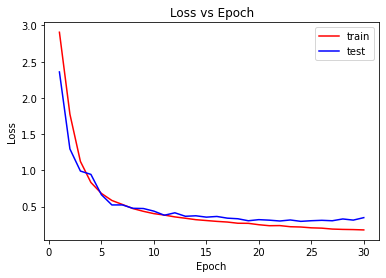

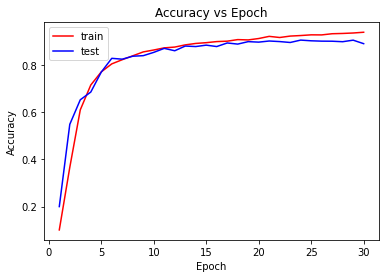

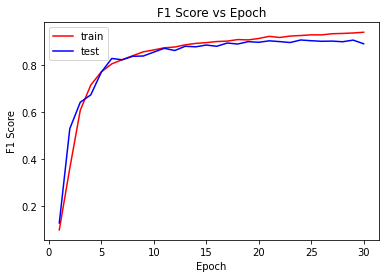

In [ ]:
x = [i + 1 for i in range(len( metrics['train loss']))]
plt.plot(x, metrics['train loss'], color='r', label='train')
plt.plot(x, metrics['test loss'], color='b', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.plot(x, metrics['train acc'], color='r', label='train')
plt.plot(x, metrics['test acc'], color='b', label='test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

plt.plot(x, metrics['train f1'], color='r', label='train')
plt.plot(x, metrics['test f1'], color='b', label='test')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Epoch")
plt.legend()
plt.show()

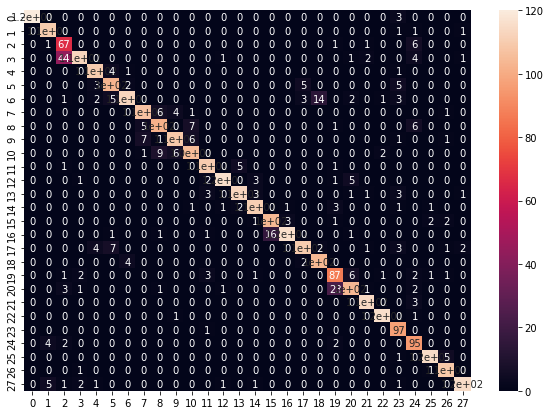

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        all_labels += labels
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        preds = torch.argmax(outputs, 1).to('cpu')
        all_preds += preds

df_cm = pd.DataFrame(confusion_matrix(all_preds,all_labels))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

Interestingly, a lot of samples from the second class are predicted as 3. This behaviour of the model suggests that classes 2 and 3 are pretty similar, which is indeed true. class2 is "ب" and class3 is "ث". The same thing has happened for classes 15("ط") and 16("ظ") as well.

# Conclusion
Though we used a very well known model, some Arabic letters are very similar to each other, which can decrease the accuracy of the model.